In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

#miscelaneous
from google.colab import files

Download the dataset 2 and dataset 3 (6000 images)

In [ ]:
#downloading the prostate cancer dataset that will be used for training
if not os.path.exists("Dataset_2.zip"):
  !gdown 1cv4i5bSuGUgxGam73D_JnAN2G4XtSFWf
  !unzip Dataset_2.zip
else:
  print("The dataset 2 has already been downloaded. Skipping this step.")

#downloading the animal faces dataset that will be used for training
if not os.path.exists("Dataset_3.zip"):
  !gdown 1flt1M8ME-5oKoZ5M3etK3Zal67FVxSJo
  !unzip Dataset_3.zip
else:
  print("The dataset has already been downloaded. Skipping this step.")

Traceback (most recent call last):
  File "/usr/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1303, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1159, in read
    return self._sslobj.read(len, buffer)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/__main__.py", line 172, in main
    download(
  File "/usr/local/lib/python3.10/dist-

Download the sample (100 images) datasets

In [2]:
# Download dataset 2 and 3 (prostate cancer and animal faces) samples
if not os.path.exists("prostate_cancer_sample.zip"):
  !gdown 1YW4jufX8l3dsBv4ivsh8enMWEWH_LgxV
  !unzip prostate_cancer_sample.zip
else:
  print("The dataset 2 sample has already been downloaded. Skipping this step.")

if not os.path.exists("animal_faces_sample.zip"):
  !gdown 1fuYVyOst7HZq4uTj46Gc2JU6nBguiLIF
  !unzip animal_faces_sample.zip
else:
  print("The dataset 3 sample has already been downloaded. Skipping this step.")

Downloading...
From: https://drive.google.com/uc?id=1YW4jufX8l3dsBv4ivsh8enMWEWH_LgxV
To: /content/prostate_cancer_sample.zip
100% 1.41M/1.41M [00:00<00:00, 11.6MB/s]
Archive:  prostate_cancer_sample.zip
   creating: prostate_cancer_sample/
   creating: prostate_cancer_sample/gland/
  inflating: prostate_cancer_sample/gland/gland.10.jpg  
  inflating: prostate_cancer_sample/gland/gland.11.jpg  
  inflating: prostate_cancer_sample/gland/gland.12.jpg  
  inflating: prostate_cancer_sample/gland/gland.13.jpg  
  inflating: prostate_cancer_sample/gland/gland.14.jpg  
  inflating: prostate_cancer_sample/gland/gland.15.jpg  
  inflating: prostate_cancer_sample/gland/gland.16.jpg  
  inflating: prostate_cancer_sample/gland/gland.17.jpg  
  inflating: prostate_cancer_sample/gland/gland.18.jpg  
  inflating: prostate_cancer_sample/gland/gland.19.jpg  
  inflating: prostate_cancer_sample/gland/gland.20.jpg  
  inflating: prostate_cancer_sample/gland/gland.21.jpg  
  inflating: prostate_cancer_sam

In [3]:
#preparing and loading the images in the dataset
def loadImagesForPreTrained(path, batch_size):
  #firstly defining the transformations used on the images
  transformation = transforms.Compose([
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  #now loading the images
  data_set = datasets.ImageFolder(path, transform=transformation)

  #creating dataloader
  data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False)

  return data_loader

Dataloaders for the 6k image datasets

In [ ]:
prostate_cancer_loader= loadImagesForPreTrained("Prostate Cancer", 64)
animal_faces_loader= loadImagesForPreTrained("Animal Faces", 64)

Dataloaders for the sample datasets

In [4]:
prostate_cancer_loader= loadImagesForPreTrained("prostate_cancer_sample", 64)
animal_faces_loader= loadImagesForPreTrained("animal_faces_sample", 64)

In [5]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shufflenet = shufflenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 37.4MB/s]


In [6]:
def extract_features_for_tsne(model, data_loader, device):

    model.eval()  # Set model to evaluation mode
    features, labels = [], []
    # Remove the classification layer (last layer) to get only feature outputs
    model_features = nn.Sequential(*list(model.children())[:-1])
    with torch.no_grad():
        for images, target_labels in data_loader:
            images = images.to(device)

            # Remove the final layer for feature extraction (assuming model_features is the model without the last layer)
            outputs = model_features(images)  # Replace model with model_features if the last layer was sliced
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())  # Flatten feature tensor
            labels.extend(target_labels.cpu().numpy())  # Collect labels on CPU for t-SNE

    # Concatenate all features for t-SNE processing
    features = np.concatenate(features, axis=0)

    return features, labels

In [9]:
features_prostate_cancer, labels_prostate_cancer = extract_features_for_tsne(shufflenet, prostate_cancer_loader, device)
features_animal_faces, labels_animal_faces = extract_features_for_tsne(shufflenet, animal_faces_loader, device)

In [7]:
def plot_tsne(features, labels, dataset_name, label_mapping):
  # Apply t-SNE
  tsne = TSNE(n_components=2, random_state=42, perplexity=max(5, min(30, features.shape[0] - 1)))
  reduced_features = tsne.fit_transform(features)

  unique_classes = np.unique(labels)
  num_classes = len(unique_classes)

  plt.figure(figsize=(10, 6))
  colors = plt.cm.get_cmap('viridis', num_classes)

  for class_index in unique_classes:
    indices = np.where(labels == class_index)
    class_name = label_mapping.get(class_index, f"Class {class_index}")
    plt.scatter(
      reduced_features[indices, 0],
      reduced_features[indices, 1],
      label= class_name,
      c=[colors(class_index)],
      alpha=0.7,
    )

  plt.title(f"t-SNE Visualization of CNN Extracted Features - {dataset_name}")
  plt.xlabel("t-SNE Feature 1")
  plt.ylabel("t-SNE Feature 2")
  plt.legend(loc='best')
  plt.show()

Plotting t-SNE for the 6k image datasets

<ipython-input-9-06dee4318f36>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


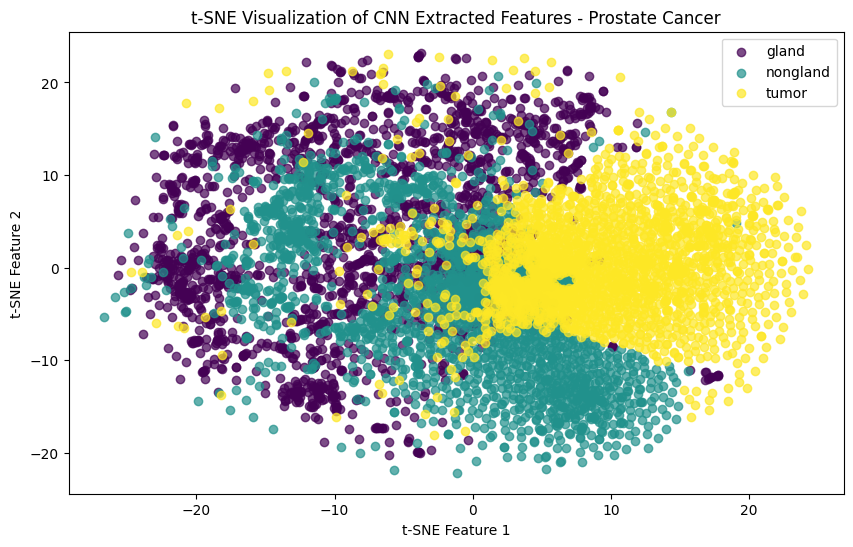

<ipython-input-9-06dee4318f36>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


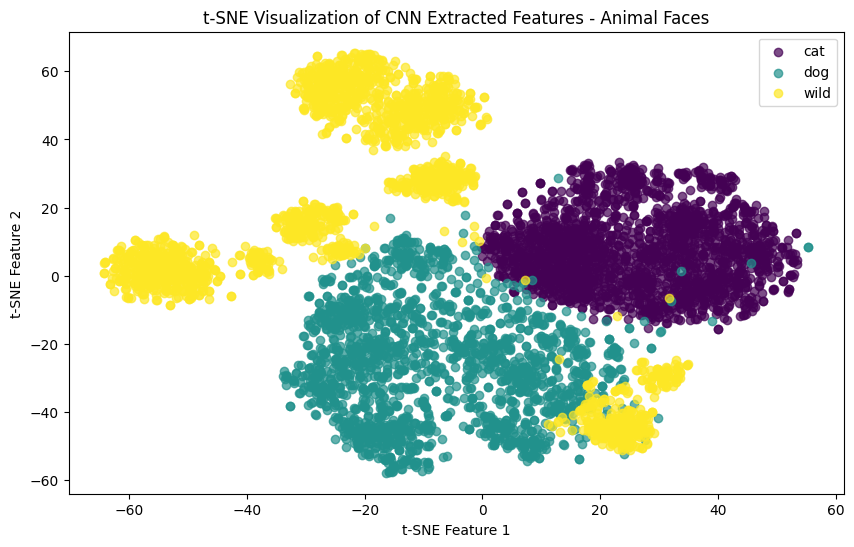

In [ ]:
# Plotting for Prostate Cancer dataset
plot_tsne(features_prostate_cancer, labels_prostate_cancer, dataset_name = "Prostate Cancer", label_mapping = {0: 'gland', 1: 'nongland', 2: 'tumor'})

# Plotting for Animal Faces dataset
plot_tsne(features_animal_faces, labels_animal_faces, dataset_name="Animal Faces", label_mapping = {0: 'cat', 1: 'dog', 2: 'wild'})

Plotting t-SNE for the sample datasets

<ipython-input-7-aeedeea5fe73>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


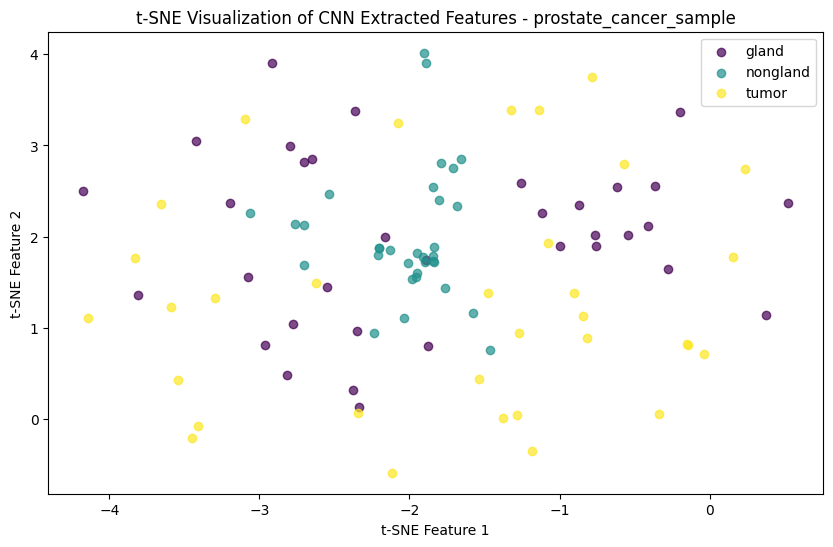

<ipython-input-7-aeedeea5fe73>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


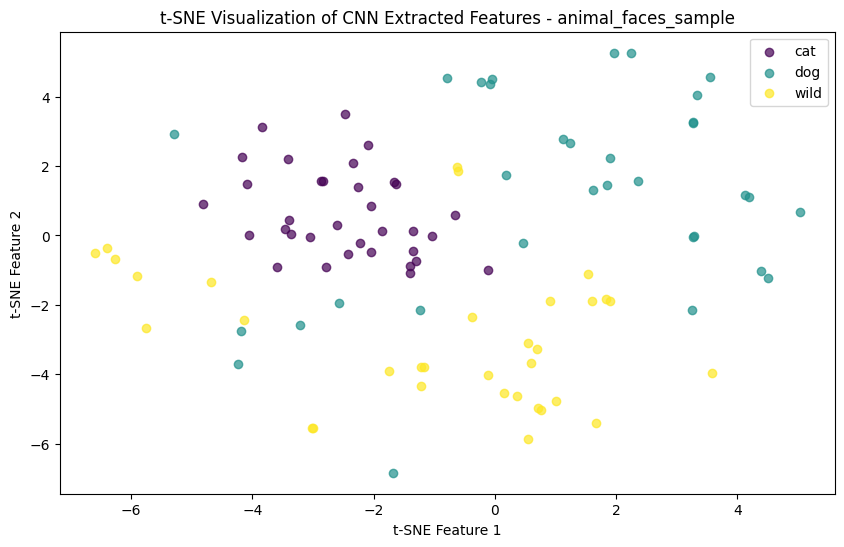

In [10]:
# Plotting for Prostate Cancer dataset sample
plot_tsne(features_prostate_cancer, labels_prostate_cancer, dataset_name = "prostate_cancer_sample", label_mapping = {0: 'gland', 1: 'nongland', 2: 'tumor'})

# Plotting for Animal Faces dataset sample
plot_tsne(features_animal_faces, labels_animal_faces, dataset_name="animal_faces_sample", label_mapping = {0: 'cat', 1: 'dog', 2: 'wild'})

For prostate cancer dataset using logistic regression:
Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       1.00      1.00      1.00         7
           2       0.55      0.55      0.55        11

    accuracy                           0.67        30
   macro avg       0.71      0.71      0.71        30
weighted avg       0.67      0.67      0.67        30



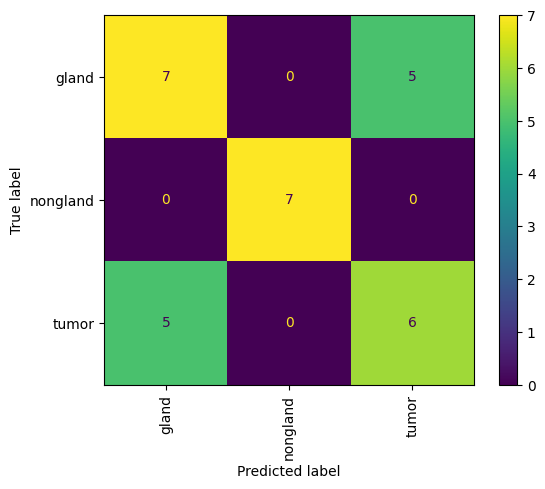

In [11]:
# Split the extracted features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_prostate_cancer, labels_prostate_cancer, test_size=0.3, random_state=42)

# Train a Logistic Regression model
lr = LogisticRegression(penalty=None)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Evaluate the classifier
print("For prostate cancer dataset using logistic regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

classes=['gland', 'nongland', 'tumor']

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=classes,
    cmap='viridis',
    xticks_rotation='vertical'
)

For animal faces dataset using SVM:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



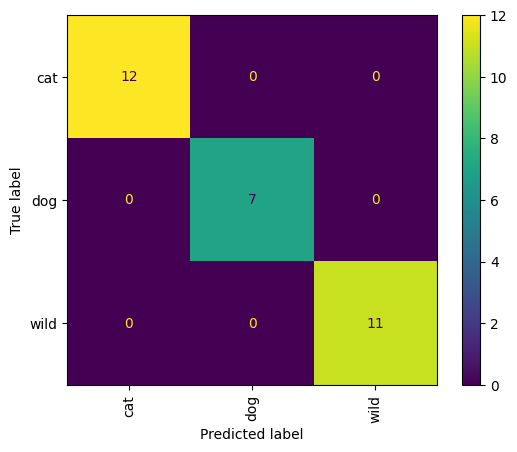

In [12]:
# Split the extracted features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_animal_faces, labels_animal_faces, test_size=0.3, random_state=42)

# Create an SVM classifier
svm = SVC(kernel='linear')

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the classifier
print("For animal faces dataset using SVM:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

classes=['cat', 'dog', 'wild']

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=classes,
    cmap='viridis',
    xticks_rotation='vertical'
)